In [1]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import uniform
from tqdm import tqdm
import time

pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv('X_clean.csv')

data.head()


,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,EnergyPerBuilding,Latitude,Longitude,RatioElectricityUse,...,Primary_Residence Hall.2,Primary_Restaurant.2,Primary_Retail Store.2,Primary_Self-Storage Facility.2,Primary_Senior Care Community.2,Primary_Small- and Mid-Sized Office.2,Primary_Supermarket / Grocery Store.2,Primary_University.2,Primary_Warehouse.2,Primary_Worship Facility.2
0,249.980000,7226362.500000,1.000000,12,88434,97,7226362.500000,47.612200,-122.337990,0.160041,...,False,False,False,False,False,False,False,False,False,False
1,295.860000,8387933.000000,1.000000,11,88502,28,8387933.000000,47.613170,-122.333930,0.113309,...,False,False,False,False,False,False,False,False,False,False
2,2089.280000,72587024.000000,1.000000,41,759392,55,72587024.000000,47.613930,-122.338100,0.199973,...,False,False,False,False,False,False,False,False,False,False
3,286.430000,6794584.000000,1.000000,10,61320,98,6794584.000000,47.614120,-122.336640,0.119437,...,False,False,False,False,False,False,False,False,False,False
4,505.010000,14172606.000000,1.000000,18,113580,44,14172606.000000,47.613750,-122.340470,0.111020,...,False,False,False,False,False,False,False,False,False,False


In [16]:
class Data:
    def __init__(self, data, y_n):
        self.epoch = 5
        self.layout = {
            'linear R2': [],
            'ridge R2': [],
            'lasso R2': [],
            'elastic R2': [],
            'ridge alpha': [],
            'lasso alpha': [],
            'elastic alpha': [],
            'elastic l1_ratio': [],
            'random forest R2': [],
            'xgboost R2': [],
            'random forest params': [],
            'xgboost params': [],
            'linear time': [],
            'ridge time': [],
            'lasso time': [],
            'elastic time': [],
            'random forest time': [],
            'xgboost time': []
        }
        self.iter = 0
        self.origin = data.copy()
        self.y_n = y_n
        self.data = data
        self.preprocess()
        self.y = self.data.iloc[:, y_n]
        self.data = self.data.iloc[:, 2:]
        print(f"Prediction {self.y.name}")
        
    def preprocess(self):
        scaler = StandardScaler()
        self.data = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)
    
    def export_predictions(self, model, data, filename='predictions.csv'):
        predictions = model.predict(data.iloc[:, 2:])
        results_df = data.copy()
        results_df['Predictions'] = predictions
        results_df.to_csv(filename, index=False)
        print(f"Les prédictions ont été exportées dans {filename}")
        
    def run(self):
        kf = KFold(n_splits=self.epoch, shuffle=True, random_state=42)
        models = [
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            RandomForestRegressor(),
            xgb.XGBRegressor()
        ]
        total_steps_per_epoch = 6
        with tqdm(total=kf.get_n_splits() * total_steps_per_epoch, desc="Epoch Progress") as pbar:
            for train_index, test_index in kf.split(self.data):
                self.X_train, self.X_test = self.data.iloc[train_index], self.data.iloc[test_index]
                self.y_train, self.y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                models[0] = self.linear_regression(models[0])
                pbar.update(1)
                models[1] = self.ridge_regression(models[1])
                pbar.update(1)
                models[2] = self.lasso_regression(models[2])
                pbar.update(1)
                models[3] = self.elastic_net(models[3])
                pbar.update(1)
                models[4] = self.random_forest_regression(models[4])
                pbar.update(1)
                models[5] = self.xgboost_regression(models[5])
                pbar.update(1)
        self.export_predictions(models[1], self.origin)        
        return self.layout

    def linear_regression(self, model):
        start_time = time.time()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        end_time = time.time()
        self.layout['linear R2'].append(r2_score(self.y_test, pred))
        self.layout['linear time'].append(end_time - start_time)
        return model

    def ridge_regression(self, model):
        start_time = time.time()
        param_distributions_ridge = {'alpha': uniform(0.01, 1000)}
        random_search_ridge = RandomizedSearchCV(model, param_distributions_ridge, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        random_search_ridge.fit(self.X_train, self.y_train)
        best_ridge = random_search_ridge.best_estimator_
        pred = best_ridge.predict(self.X_test)
        end_time = time.time()
        self.layout['ridge R2'].append(r2_score(self.y_test, pred))
        self.layout['ridge alpha'].append(random_search_ridge.best_params_['alpha'])
        self.layout['ridge time'].append(end_time - start_time)
        return best_ridge

    def lasso_regression(self, model):
        start_time = time.time()
        param_distributions_lasso = {'alpha': uniform(0.01, 1000)}
        random_search_lasso = RandomizedSearchCV(model, param_distributions_lasso, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        random_search_lasso.fit(self.X_train, self.y_train)
        best_lasso = random_search_lasso.best_estimator_
        pred = best_lasso.predict(self.X_test)
        end_time = time.time()
        self.layout['lasso R2'].append(r2_score(self.y_test, pred))
        self.layout['lasso alpha'].append(random_search_lasso.best_params_['alpha'])
        self.layout['lasso time'].append(end_time - start_time)
        return best_lasso

    def elastic_net(self, model):
        start_time = time.time()
        param_distributions_elastic_net = {
            'alpha': uniform(0.01, 1000),
            'l1_ratio': uniform(0, 1)
        }
        random_search_elastic_net = RandomizedSearchCV(model, param_distributions_elastic_net, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        random_search_elastic_net.fit(self.X_train, self.y_train)
        best_elastic_net = random_search_elastic_net.best_estimator_
        pred = best_elastic_net.predict(self.X_test)
        end_time = time.time()
        self.layout['elastic R2'].append(r2_score(self.y_test, pred))
        self.layout['elastic alpha'].append(random_search_elastic_net.best_params_['alpha'])
        self.layout['elastic l1_ratio'].append(random_search_elastic_net.best_params_['l1_ratio'])
        self.layout['elastic time'].append(end_time - start_time)
        return best_elastic_net

    def random_forest_regression(self, model):
        start_time = time.time()
        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        random_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
        random_search_rf.fit(self.X_train, self.y_train)
        best_rf = random_search_rf.best_estimator_
        pred = best_rf.predict(self.X_test)
        end_time = time.time()
        self.layout['random forest R2'].append(r2_score(self.y_test, pred))
        self.layout['random forest params'].append(random_search_rf.best_params_)
        self.layout['random forest time'].append(end_time - start_time)
        return best_rf

    def xgboost_regression(self, model):
        start_time = time.time()
        param_distributions_xgb = {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 6, 10],
            'learning_rate': uniform(0.01, 0.3),
            'alpha': uniform(0, 1)
        }
        random_search_xgb = RandomizedSearchCV(model, param_distributions_xgb, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1)
        random_search_xgb.fit(self.X_train, self.y_train)
        best_xgb = random_search_xgb.best_estimator_
        pred = best_xgb.predict(self.X_test)
        end_time = time.time()
        self.layout['xgboost R2'].append(r2_score(self.y_test, pred))
        self.layout['xgboost params'].append(random_search_xgb.best_params_)
        self.layout['xgboost time'].append(end_time - start_time)
        return best_xgb

In [17]:
df = Data(data, 1)

res = pd.DataFrame(df.run())
res.head()



Prediction SiteEnergyUse(kBtu)


Epoch Progress: 100%|██████████| 30/30 [01:34<00:00,  3.17s/it]


Les prédictions ont été exportées dans predictions.csv


,linear R2,ridge R2,lasso R2,elastic R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest R2,xgboost R2,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-68372881472532364927172608.000000,0.950792,-0.001674,-0.001674,58.093612,374.550119,374.550119,0.950714,0.958928,0.974391,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.06505159298527952, 'learning_rate'...",0.042081,0.871287,0.575075,0.570686,11.215956,6.364617
1,-17549018956525745999970304.000000,0.903470,-0.005550,-0.005550,20.594494,374.550119,374.550119,0.950714,0.898817,0.988757,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.5247564316322378, 'learning_rate':...",0.047067,0.737828,0.562618,0.534266,10.341196,6.375338
2,-281739838864452411719680.000000,0.984437,-0.000303,-0.000303,20.594494,374.550119,374.550119,0.950714,0.948484,0.938215,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.056411579027100256, 'learning_rate...",0.047409,0.726338,0.567443,0.465567,10.139023,6.379058
3,-418348631016738702575534080.000000,0.987761,-0.000000,-0.000000,20.594494,374.550119,374.550119,0.950714,0.905565,0.949183,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.5247564316322378, 'learning_rate':...",0.047127,0.725781,0.562937,0.542027,10.492267,6.311972
4,-6001497732058304091258880.000000,0.930503,-0.000010,-0.000010,20.594494,374.550119,374.550119,0.950714,0.814273,0.857727,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.5247564316322378, 'learning_rate':...",0.046639,0.720631,0.569278,0.550329,11.527805,6.229394


              index         0
0         linear R2 -1.000000
1          ridge R2  0.951393
2          lasso R2 -0.001507
3        elastic R2 -0.001507
4  random forest R2  0.914657
5        xgboost R2  0.941654


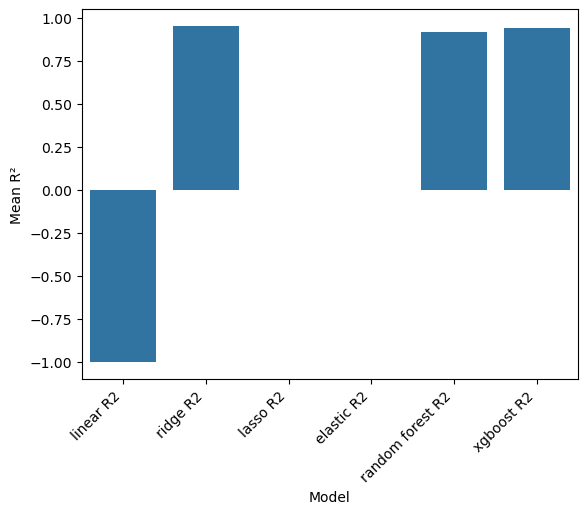

In [ ]:
list_r2  = ['linear R2', 'ridge R2', 'lasso R2', 'elastic R2','random forest R2','xgboost R2']
res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

scores_r2 = res[list_r2].mean().reset_index()
print(scores_r2)
scores_r2.columns = ['Model', 'Mean R²']
sns.barplot(x='Model', y='Mean R²', data=scores_r2)
plt.xticks(rotation=45, ha='right')
plt.show()

                index         0
0         linear time  0.051246
1          ridge time  1.476323
2          lasso time  0.586045
3        elastic time  0.584618
4  random forest time 10.773920
5        xgboost time  6.941178


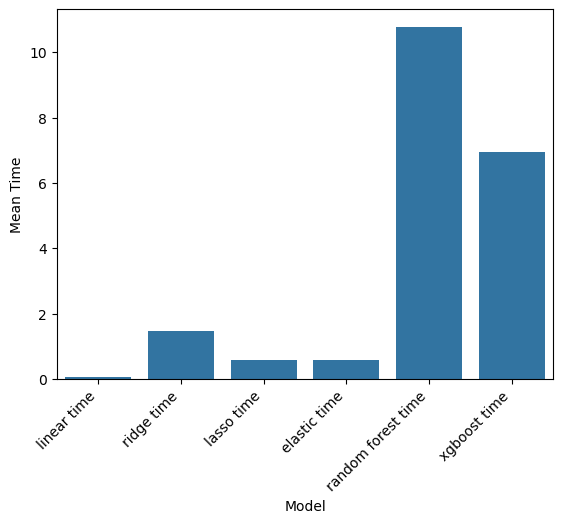

In [ ]:
time = res[['linear time',	'ridge time',	'lasso time',	'elastic time',	'random forest time',	'xgboost time']].mean().reset_index()
print(time)
time.columns = ['Model', 'Mean Time']
sns.barplot(x='Model', y='Mean Time', data=time)
plt.xticks(rotation=45, ha='right')
plt.show()